In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten,Dense
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Dataset Completo/DataframeCompleto.csv", index_col = 0)
df = df[['frente','Montante bancário']]

In [218]:
def rotate_image(image, angle):
    (height, width) = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

In [ ]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf


# Output path for augmented images
output_folder = 'dataset_montante_aumentado2'
label_0_folder = os.path.join(output_folder, '0')
label_1_folder = os.path.join(output_folder, '1')

# Create subfolders if they don't exist
os.makedirs(label_0_folder, exist_ok=True)
os.makedirs(label_1_folder, exist_ok=True)

import tensorflow as tf
import numpy as np

def augment_image(image):
    angles = [-10, -5, -3, 3, 5, 10]
    angle = np.random.choice(angles)
    image = rotate_image(image,angle) 
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

count = 0

for index, row in df.iterrows():
    file_path = row['frente']
    label = int(row['Montante bancário'])  # True/False → 1/0
    
    # Load and preprocess the image
    image = cv.imread(file_path, cv.IMREAD_GRAYSCALE)
    x, y, w, h = 350, 73, 300, 28
    image = image[y:y+h, x:x+w]
    if image is None:
        print(f"⚠️ Failed to load image: {file_path}")
        continue
    
    # Resize and normalize
    image = cv.resize(image, (28, 234))
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB (needed for tf.image)

    # Select the correct folder based on label
    folder = label_1_folder if label == 1 else label_0_folder

    # Save original image
    original_filename = f"{index}_original.png"
    cv.imwrite(os.path.join(folder, original_filename), image)

    # Generate 6 augmented versions per image
    for i in range(6):
        augmented_image = augment_image(image)
        augmented_image = tf.keras.utils.array_to_img(augmented_image)
        
        # Save augmented image in correct label folder
        filename = f"{index}_aug_{i}.png"
        augmented_image.save(os.path.join(folder, filename))
        
        count += 1

print(f"Generated {count} augmented images.")


✅ Generated 1068 augmented images.


In [232]:
pasta = 'dataset_montante_aumentado2'
subpastas = ['0','1']

montante_bancario = []

for p in subpastas:
    caminho = os.path.join(pasta, p)
    label = int(p)
    for imagem in os.listdir(caminho):
        imagem_caminho = os.path.join(caminho,imagem)
        img = cv.imread(imagem_caminho,0)
        montante_bancario.append({'caminho':imagem_caminho,'imagem':img,'label':label})

df_montante = pd.DataFrame(montante_bancario)

In [233]:
df_montante = df_montante[df_montante.columns[1:]]

In [234]:
df_montante.head()

,imagem,label
0,"[[66, 77, 69, 71, 112, 120, 133, 133, 145, 175...",0
1,"[[85, 93, 86, 89, 126, 131, 144, 143, 153, 182...",0
2,"[[50, 61, 53, 55, 100, 108, 123, 122, 135, 168...",0
3,"[[0, 0, 0, 0, 0, 0, 170, 195, 199, 202, 206, 2...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 138, 182, 187,...",0


In [235]:
df_sem = df_montante[df_montante['label'] == 0]
df_com = df_montante[df_montante['label'] == 1]

df_sem_upsampled = df_sem.sample(len(df_com), replace=True, random_state=42)

df_balanced = pd.concat([df_com, df_sem_upsampled], ignore_index=True)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total images in balanced DataFrame: {len(df_balanced)}")

Total images in balanced DataFrame: 2296


In [278]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# First, split into train + validation (85% train, 15% validation)
train_df, val_df = train_test_split(
    df_balanced, 
    test_size=0.15,   # 15% for validation
    random_state=2, 
    stratify=df_balanced['label']
)

# Stack images into a single 4D NumPy array
x_train = np.stack(train_df['imagem'].values)
x_val = np.stack(val_df['imagem'].values)

# Convert labels to numpy arrays
y_train = np.array(train_df['label'])
y_val = np.array(val_df['label'])

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")


Training set size: 1951
Validation set size: 345


In [279]:
# Adicionar a dimensão do canal
train_dataset = train_dataset.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))
val_dataset = val_dataset.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))

# Normalização
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Criar batches corretamente
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [281]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(28, 234, 1)))  # Fewer filters
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))  # Fewer filters
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model.add(Flatten())

model.add(Dense(64, activation='relu'))  # Fewer neurons
model.add(Dropout(0.5))  # Dropout to prevent overfitting

model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(0.05)))  # Binary classification

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,       
    restore_best_weights=True
)


In [282]:
# Treino do modelo
#class_weights = {0: 0.6, 1: 0.4}
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    callbacks = [early_stopping]
)

Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5883 - loss: 0.7778 - val_accuracy: 0.9594 - val_loss: 0.5783
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9040 - loss: 0.4813 - val_accuracy: 1.0000 - val_loss: 0.1798
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9778 - loss: 0.2023 - val_accuracy: 1.0000 - val_loss: 0.1018
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9871 - loss: 0.1354 - val_accuracy: 0.9971 - val_loss: 0.0846
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9899 - loss: 0.1092 - val_accuracy: 0.9971 - val_loss: 0.0726
Epoch 6/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9895 - loss: 0.1023 - val_accuracy: 1.0000 - val_loss: 0.0575
Epoch 7/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9921 - loss: 0.0829 - val_accuracy: 1.0000 - val_loss: 0.0482
Epoch 8/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9969 - loss: 0.0676 - val_accuracy: 1.0000 - v

In [283]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0170
Validation Accuracy: 100.00%


In [276]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 234, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [285]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9759 - loss: 14.8484
Test Accuracy: 0.97


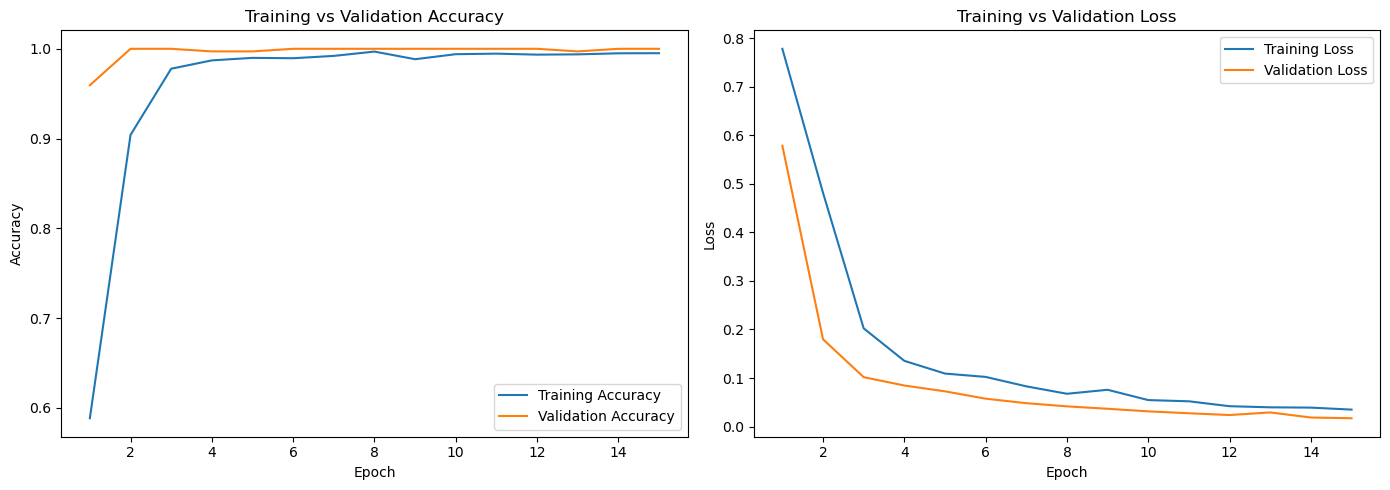

In [287]:
import matplotlib.pyplot as plt

# Dados
epochs = list(range(1, 16))
accuracy = [0.5883, 0.9040, 0.9778, 0.9871, 0.9899, 0.9895, 0.9921, 0.9969, 0.9884, 0.9940, 0.9946, 0.9935, 0.9938, 0.9950, 0.9951]
val_accuracy = [0.9594, 1.0000, 1.0000, 0.9971, 0.9971, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9971, 1.0000, 1.0000]

loss = [0.7778, 0.4813, 0.2023, 0.1354, 0.1092, 0.1023, 0.0829, 0.0676, 0.0758, 0.0546, 0.0521, 0.0420, 0.0397, 0.0391, 0.0350]
val_loss = [0.5783, 0.1798, 0.1018, 0.0846, 0.0726, 0.0575, 0.0482, 0.0417, 0.0367, 0.0314, 0.0275, 0.0238, 0.0292, 0.0187, 0.0172]

# Gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Accuracy plot
ax1.plot(epochs, accuracy, label='Training Accuracy')
ax1.plot(epochs, val_accuracy, label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training vs Validation Accuracy')
ax1.legend()

# Loss plot
ax2.plot(epochs, loss, label='Training Loss')
ax2.plot(epochs, val_loss, label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training vs Validation Loss')
ax2.legend()

# Ajustar layout
plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


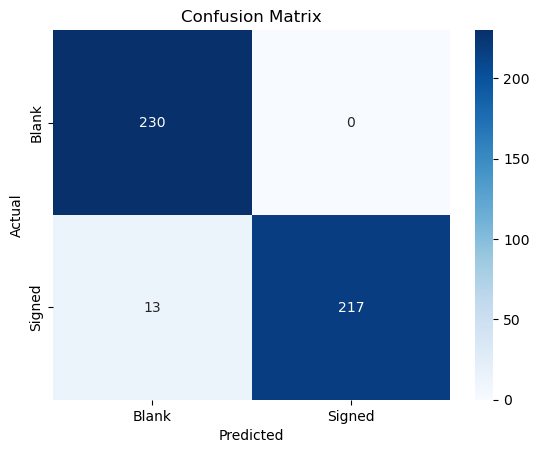

              precision    recall  f1-score   support

       Blank       0.95      1.00      0.97       230
      Signed       1.00      0.94      0.97       230

    accuracy                           0.97       460
   macro avg       0.97      0.97      0.97       460
weighted avg       0.97      0.97      0.97       460



In [286]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(x_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Blank', 'Signed'], yticklabels=['Blank', 'Signed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Blank', 'Signed']))

In [243]:
model.save("ModeloMontanteBancario2.keras")